# アニーリングアルゴリズムの評価

アニーリングアルゴリズムはヒューリスティクスの一つなので毎回最適解を出せるとは限りません。近似解を出すためのアルゴリズムです。
また、確率的アルゴリズムなので毎回解が異なります。  
そのためアルゴリズムの評価をする際は様々な平均値を持って解を評価します。よく用いられる手法が

- 成功確率 or エラー確率
- TTS : Time to solution
- 残留エネルギー : Resudial energy

の3つです。特にTTSは計算時間を表すので評価としてよく用いられます。残留エネルギーは最適解にどれくらい近づけたかを平均的に示す値です。
まず、TTSから見ていきましょう。

## Time to solution

TTS は計算時間を表しますが、アニーリングアルゴリズムはどの計算時間でも何かしらの解を出すことができるので計算時間といってもただ計算時間を測るのではなく、何かしら別の指標が必要です。安直に思いつくのはある確率以上で解がでるために必要な計算時間です。しかし、"1-Introduction"でも行なったようにアニーリングアルゴリズムは複数回行って解を探すため、計算時間を評価するには複数回行うことも考慮に入れなければなりません。

そこで複数回アニーリングを行うことも考慮に入れたのがTime to solution(TTS)です。TTSは簡単に導くことができます。

ここで1回のアニーリング時間を$\tau$とし、1回の$\tau$時間のアニーリングで最適解を得る確率を$p_s(\tau)$としましょう(sはsuccessです)。  
すると$R$回$\tau$時間のアニーリングを行って1回でも最適解を得る確率$p_R$は
$$p_R = 1-(1-p_s(\tau))^R$$
となります。第二項は$R$回やっても最適解を得られない(間違える)確率なのでそれを1から引けば$R$回やって最適解を得られる確率になります。
この式を$R$について解きましょう。すると
$$R = \frac{\ln(1-p_R)}{\ln(1-p_s(\tau))}$$
となります。これに1回の計算時間$\tau$をかけるとトータルの計算時間となるのでそれがTime to solution (TTS)です。
$$TTS(\tau, p_R) = \tau R = \tau \frac{\ln(1-p_R)}{\ln(1-p_s(\tau))}$$
$TTS(\tau, p_R)$が示すのは計算時間が$\tau$の一回のアニーリングで確率$p_s(\tau)$で最適解が得られる時、確率$p_R$で最適解が得られるまでの繰り返し回数も考慮した総計算時間になります。

実際の計算の評価では、$p_R$を定数で与えます。$p_R=0.99$などにすることが多いかと思います。そして様々なアニーリング時間$\tau$で$p_s(\tau)$を計算して、それらを使って$TTS(\tau, p_R)$を計算します。

### OpenJij で実験を行ってTTSを測る

では以下では実際にOpenJijを使ってTTSを図ってみましょう。  
本当は具体的な問題がいいのですが、問題の説明などが面倒なので、相互作用にランダム性が入っていおり、最適解のスピンの上下がちぐはぐになる問題(物理では反強磁性といいます)を考えます。
具体的にはランダム性の入った1次元反強磁性モデルという問題を考えます(例題が物理に寄りすぎているのでだれか他の問題でここを書き直してほしい ex. 頂点被覆とか)。

Ising モデルを考えます。

$$H(\{\sigma_i\}) = \sum_{i=0}^{N-1} J_{i, i+1}\sigma_i \sigma_{i+1} + \sum_{i=0}^{N-1} h_i \sigma_i$$

ここで$J_{ij} \in [0.1, 1.0]$とし、$h_0 = -1$で他の縦磁場は0とします。$J_{ij} > 0$なので各スピンは違う向きに向いた方がエネルギーが下がります。なので最適解となる$\{\sigma_i\}$は$1, -1, 1,\cdots$ のように値が交互になります。また$h_0=-1$としているので、最初のスピンは$\sigma_0 =1$になります。よって最適解は $1, -1, 1, \cdots$です。

つまり$TTS$は$1, -1, 1, \cdots$を得るためにかかる総計算時間となります。  
以下では上記のIsing モデルをといて、1回の計算時間を延ばすとTTSがどう変化するかを見てみましょう。

In [118]:
import random
import time 
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj

In [119]:
# 反強磁性1次元イジングモデル を作る.
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

In [120]:
# 最適解
correct_state = [(-1)**i for i in range(N)]

# TTS を計算するのに必要なp^R
pR = 0.99

# Samplerの引数のstep_num というパラメータに渡すリスト(step_num_list) 
# step_num はアニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数だと思って良い
# なので増やせば増やすほどゆっくりアニーリングすることになってアニーリング時間が伸びる。
step_num_list = [10, 20, 30, 40]

# 各計算時間に対するTTSを格納しておくリスト
TTS_list = []
tau_list = []  # 計算時間を格納しておくリスト

iteration = 2000  # 確率を計算するために1回のアニーリングを行う回数

for step_num in step_num_list:
    start = time.time()
    # beta_max と　beta_min はSAのアルゴリズムで使うパラメータ. 今は特に気にしなくて良い.
    sampler = oj.SASampler(beta_max=10.0, beta_min=0.01, step_num=step_num, iteration=iteration)  # 確率p_sを計算するために500回計算する
    tau = (time.time() - start)/iteration  # 1回のアニーリング時間の計算時間の計測
    
    response = sampler.sample_ising(h, J)
    # 返ってきた解であっている状態の数を数えて最適解を得た確率を計算する。
    ps = sum([1 if state == correct_state else 0 for state in response.states])/iteration
    
    # ps=0だとTTSが無限大になってしまうのでそこは回避
    if ps == 0:
        continue
    
    # TTSを計算する
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau)
    tau_list.append(tau)

Text(0, 0.5, 'TTS')

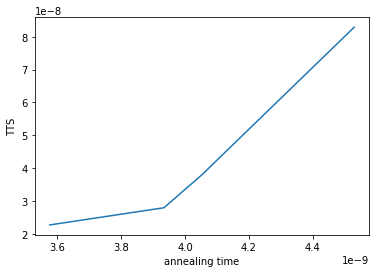

In [121]:
plt.plot(tau_list, TTS_list)
plt.xlabel('annealing time')
plt.ylabel('TTS')

1回あたりの計算時間がブレてしまうのが難点ですが、とりあえず計算することができました。
ちなみにOpenJijにはデフォルトでTTS, 残留エネルギー, エラー確率を評価してくれる関数が付いています。

In [124]:
result = oj.benchmark(true_ground_states=[correct_state], ground_energy=0, 
                      solver= lambda time_param, iteration: oj.SASampler(step_num=time_param, iteration=iteration).sample_ising(h,J),
                      time_param_list=step_num_list)

time parameter:  10
time parameter:  20
time parameter:  30
time parameter:  40


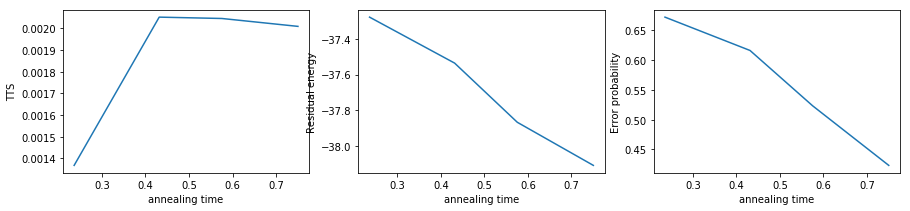

In [131]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['e_res'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['error'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Error probability', fontsize=fontsize)

fig.show()